# Linear Programming Application Handbook

This guide is designed to demonstrate problem-modeling techniques using example scenarios similar to those one may encounter in everyday life or work.

All text and code in this handbook is released under the [CC-BY-SA 4.0 license](https://creativecommons.org/licenses/by-sa/4.0/) and the [MIT license](https://choosealicense.com/licenses/mit/).

In [2]:
# Julia 1.6.0
using JuMP, GLPK
using LinearAlgebra
using DataFrames

## Laundromat machine selection

A person wants to wash a load of clothes in a laundromat. The laundromat has the following machines:

- 3 machines of 1-unit capacity, costing 2.25
- 3 machines of 2-unit capacity, costing 3.25
- 3 machines of 3-unit capacity, costing 5.00

How should the person choose machines in the laundromat in order to minimize the total cost?

We can represent this problem as an integer linear program. In this approach, our program will minimize the objective function $\mathbf{type\_cost}\cdot\mathbf{x}$, where $\mathbf{type\_cost}$ is a vector of costs for each machine type, and $\mathbf{x}$ is a vector of decision variables, where each $x_i \in \mathbf{x}$ represents the number of machines recommended to be used, for $i$ machine type.

Our program is subject to the following constraints:

1. $\mathbf{x} \subseteq \mathbb{N}^m$, since we can't select part of an individual machine or select negative machines.
2. $0 \leq \mathbf{x} \leq \mathbf{type\_count}$, where $\mathbf{type\_count}$ is a vector of how many machines are available for each machine type.
3. $\mathbf{type\_capacity} \cdot \mathbf{x} \geq \mathit{load}$, where $\mathbf{type\_capacity}$ is a vector of the capacities of each machine type, and $\mathit{load}$ is the size of the load we want to wash.

We define $\mathbf{type\_cost}$, $\mathbf{type\_capacity}$, and $\mathbf{type\_count}$. 

In [2]:
type_cost = [2.25, 3.25, 5.00];
type_capacity = [1, 2, 3];
type_count = [3, 3, 3];

In [9]:
laundromat = DataFrame(
    cost = [2.25, 3.25, 5.00],
    capacity = [1, 2, 3],
    count = [3, 3, 3]
)

,cost,capacity,count
,Float64,Int64,Int64
1,2.25,1,3
2,3.25,2,3
3,5.0,3,3


We initialize the solver.

In [13]:
laundromat_model = Model(GLPK.Optimizer);

We define $\mathbf{x}$, as well as constraints 1 and 2.

In [14]:
@variable(laundromat_model, x[1:size(laundromat.count,1)], Int)

@constraint(laundromat_model, 0 .<= x .<= laundromat.count)

3-element Vector{ConstraintRef{Model, MathOptInterface.ConstraintIndex{MathOptInterface.ScalarAffineFunction{Float64}, MathOptInterface.Interval{Float64}}, ScalarShape}}:
 x[1] ∈ [0.0, 3.0]
 x[2] ∈ [0.0, 3.0]
 x[3] ∈ [0.0, 3.0]

We define our objective function $\mathbf{type\_cost}\cdot\mathbf{x}$.

In [15]:
@objective(laundromat_model, Min, dot(laundromat.cost, x))

2.25 x[1] + 3.25 x[2] + 5 x[3]

We implement constraint 3, and run our solver for every value $\{ \mathit{load} | \mathit{load} \in \mathbb{Z} \wedge 1 \leq \mathit{load} \leq \mathbf{type\_capacity}\cdot\mathbf{type\_count} \}$.

In [6]:
@constraint(machine_type_model, total_capacity, dot(type_capacity, x) >= 0)
machine_type_counts = []
machine_type_prices = []

loads = 1:dot(type_capacity, type_count)

for load in loads
    set_normalized_rhs(total_capacity, load)
    optimize!(machine_type_model);
    push!(machine_type_counts, transpose(value.(x)))
    push!(machine_type_prices, objective_value(machine_type_model))
end

We print our model after the run.

In [7]:
print(machine_type_model)

Min 2.25 x[1] + 3.25 x[2] + 5 x[3]
Subject to
 total_capacity : x[1] + 2 x[2] + 3 x[3] ≥ 18.0
 x[1] ∈ [0.0, 3.0]
 x[2] ∈ [0.0, 3.0]
 x[3] ∈ [0.0, 3.0]
 x[1] integer
 x[2] integer
 x[3] integer


We show the results of the solver as a DataFrame. The first column is the load size, the second through fourth columns are the values for each $x_i \in \mathbf{x}$, the fifth column is the total cost, and the last column is the difference between the purchased capacity and load size for each solution, which represents the waste/excess.

In [8]:
using DataFrames

In [9]:
machine_results = DataFrame(
    load = loads,
    x₁ = (Int64∘round).(vcat(machine_type_counts...)[:,1]),
    x₂ = (Int64∘round).(vcat(machine_type_counts...)[:,2]),
    x₃ = (Int64∘round).(vcat(machine_type_counts...)[:,3]),
    total_cost = machine_type_prices,
    waste = (Int64∘round).(vcat(machine_type_counts...) * type_capacity)-loads
)

,load,x₁,x₂,x₃,total_cost,waste
,Int64,Int64,Int64,Int64,Any,Int64
1,1,1,0,0,2.25,0
2,2,0,1,0,3.25,0
3,3,0,0,1,5.0,0
4,4,0,2,0,6.5,0
5,5,0,1,1,8.25,0
6,6,0,3,0,9.75,0
7,7,0,2,1,11.5,0
8,8,0,1,2,13.25,0
9,9,0,3,1,14.75,0


We plot the results of the total cost as dependent on the load size.

In [10]:
using Plots

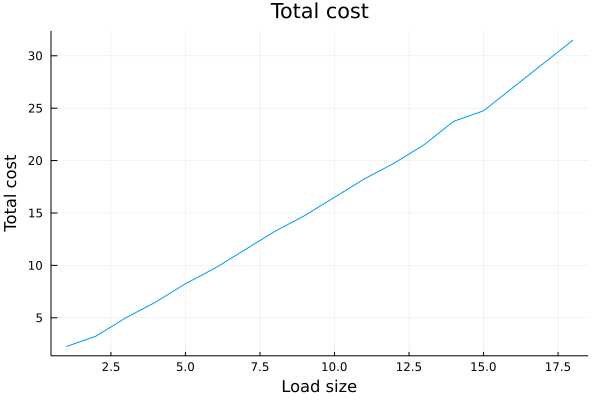

In [11]:
plot(
    loads, machine_type_prices;
    label=:none,
    title="Total cost",
    legend=:topleft,
    xlabel="Load size",
    ylabel="Total cost"
)

We plot the waste/excess as dependent on the required quantity.

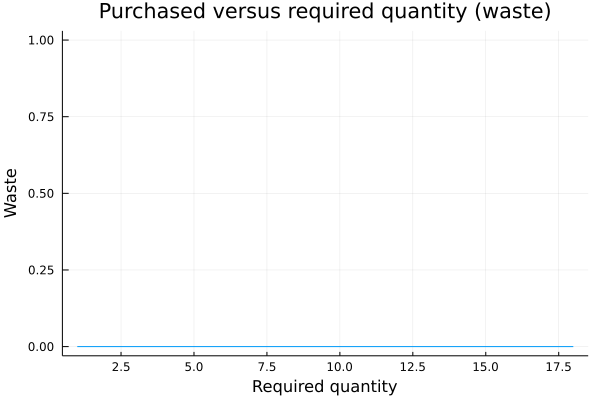

In [12]:
plot(
    loads, machine_results.waste;
    label=:none,
    title="Purchased versus required quantity (waste)",
    xlabel="Required quantity",
    ylabel="Waste"
    )

We calculate the maximum possible waste/excess.

In [13]:
maximum(machine_results.waste)

0

### Observations

We were able to efficiently solve this problem for all possible load sizes, and we can easily verify that each solution is mathematically optimal.

That said, this model in itself doesn't take into account the real-world nuances of laundry. Clothes come in many different shapes and sizes, and this makes laundering them a bit more complicated. Our model treats a load of clothes as an infinitely divisible scalar quantity rather than as a set of highly-dimensional elements.

## Wallplate pack selection

An electrician needs to buy wall plates for a job. The hardware store has the following in stock:

- 264 1-packs, costing 0.65
- 25 10-packs, costing 5.27 for quantities less than 20, and costing 4.48 for quantities of 20 or more

Given a quantity of plates needed, how does the electrician choose how many of each pack to purchase?

We can represent this problem as an integer linear program. In this approach, our program will minimize the objective function $\mathbf{pack\_cost}\cdot\mathbf{x}$, where $\mathbf{pack\_cost}$ is a vector of costs for each wallplate pack, and $\mathbf{x}$ is a vector of decision variables, where each $x_i \in \mathbf{x}$ represents the number of packs to be purchased, for $i$ pack.

Our program is subject to the following constraints:

1. $\mathbf{x} \in \mathbb{Z}$, since the electrician can't purchase part of a pack.
2. $0 \preceq \mathbf{x} \preceq \mathbf{pack\_count}$, where $\mathbf{pack\_count}$ is a vector of how many units are in stock for each pack.
3. $x_3 \in \{0\}\cup \left[20,\mathit{pack\_count_3}\right]$, where $\mathit{pack\_count_3}$ is the number of units in stock for the 10-pack.
4. $x_2 + x_3 \leq \mathit{pack\_count_3}$, since $x_2$ and $x_3$ both represent quantities of the same 10-packs.
5. $\mathbf{pack\_capacity} \cdot \mathbf{x} \geq \mathit{quantity}$, where $\mathbf{pack\_capacity}$ is a vector of the size of each pack, and $\mathit{quantity}$ is the number of wallplates the electrician needs.

We define $\mathbf{pack\_cost}$, $\mathbf{pack\_capacity}$, and $\mathbf{pack\_count}$. 

In [14]:
pack_cost = [0.65, 5.27, 4.48];
pack_capacity = [1, 10, 10];
pack_count = [264, 25, 25];

We initialize the solver.

In [15]:
pack_model = Model(GLPK.Optimizer);

We define $\mathbf{x}$, as well as constraints 1 and 2.

In [16]:
@variable(pack_model, x[1:size(pack_count,1)], Int)

@constraint(pack_model, 0 .<= x[1:size(pack_count,1)] .<= pack_count)

3-element Vector{ConstraintRef{Model, MathOptInterface.ConstraintIndex{MathOptInterface.ScalarAffineFunction{Float64}, MathOptInterface.Interval{Float64}}, ScalarShape}}:
 x[1] ∈ [0.0, 264.0]
 x[2] ∈ [0.0, 25.0]
 x[3] ∈ [0.0, 25.0]

We define constraints 3 and 4.

In [17]:
@constraint(pack_model, x[3] in MOI.Semiinteger(20.0, Float64(pack_count[3])))
@constraint(pack_model, sum(x[2:3]) <= pack_count[3])

x[2] + x[3] ≤ 25.0

We define our objective function.

In [18]:
@objective(pack_model, Min, dot(pack_cost, x))

0.65 x[1] + 5.27 x[2] + 4.48 x[3]

We implement constraint 5, and run our solver for every value $\{ \mathit{quantity} | \mathit{quantity} \in \mathbb{Z} \wedge 1 \leq \mathit{quantity} \leq \sum_{i=1}^{2} c_i n_i \forall c_i,n_i \in \mathbf{pack\_capacity}, \mathbf{pack\_count} \}$.

In [19]:
@constraint(pack_model, total_capacity, dot(pack_capacity, x) >= 0)
pack_counts = []
pack_prices = []

quantities = 1:dot(pack_capacity[1:2], pack_count[1:2])

for quantity in quantities
    set_normalized_rhs(total_capacity, quantity)
    optimize!(pack_model);
    push!(pack_counts, transpose(value.(x)))
    push!(pack_prices, objective_value(pack_model))
end

We print our model after the run.

In [20]:
print(pack_model)

Min 0.65 x[1] + 5.27 x[2] + 4.48 x[3]
Subject to
 total_capacity : x[1] + 10 x[2] + 10 x[3] ≥ 514.0
 x[2] + x[3] ≤ 25.0
 x[1] ∈ [0.0, 264.0]
 x[2] ∈ [0.0, 25.0]
 x[3] ∈ [0.0, 25.0]
 x[3] ∈ MathOptInterface.Semiinteger{Float64}(20.0, 25.0)
 x[1] integer
 x[2] integer
 x[3] integer


We show the results of the solver as a DataFrame (truncated to 30 rows). The first column is the required quantity. The second through fourth columns are the values for each $x_i \in \mathbf{x}$. The fifth column is the total cost. The sixth column is the difference between the purchased quantity and required quantity for each solution, which represents the waste/excess. The seventh column is the average unit cost of an individual wallplate for the purchased quantity.

In [21]:
pack_results = DataFrame(
    quantity = quantities,
    x₁ = (Int64∘round).(vcat(pack_counts...)[:,1]),
    x₂ = (Int64∘round).(vcat(pack_counts...)[:,2]),
    x₃ = (Int64∘round).(vcat(pack_counts...)[:,3]),
    total_cost = pack_prices,
    waste = (Int64∘round).((vcat(pack_counts...) * pack_capacity)-quantities),
    unit_cost = round.(pack_prices ./ (vcat(pack_counts...) * pack_capacity); digits=2)
)

,quantity,x₁,x₂,x₃,total_cost,waste,unit_cost
,Int64,Int64,Int64,Int64,Any,Int64,Float64
1,1,1,0,0,0.65,0,0.65
2,2,2,0,0,1.3,0,0.65
3,3,3,0,0,1.95,0,0.65
4,4,4,0,0,2.6,0,0.65
5,5,5,0,0,3.25,0,0.65
6,6,6,0,0,3.9,0,0.65
7,7,7,0,0,4.55,0,0.65
8,8,8,0,0,5.2,0,0.65
9,9,0,1,0,5.27,1,0.53


We plot the results of the total cost as dependent on the quantity.

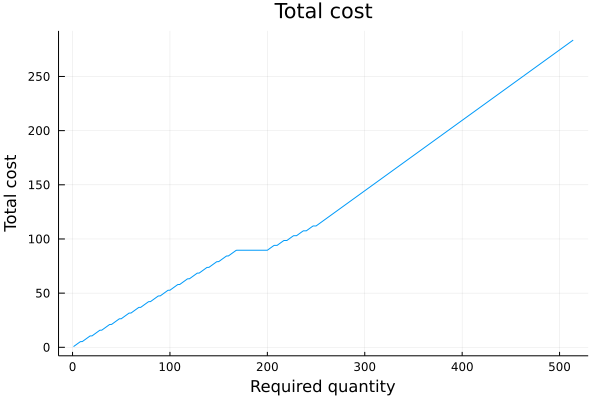

In [22]:
plot(
    quantities, pack_prices;
    label=:none,
    title="Total cost",
    legend=:topleft,
    xlabel="Required quantity",
    ylabel="Total cost"
)

We plot the waste/excess as dependent on the required quantity.

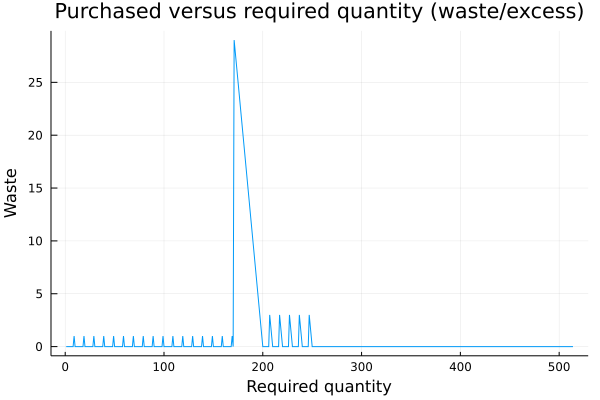

In [23]:
plot(
    quantities, pack_results.waste;
    label=:none,
    title="Purchased versus required quantity (waste/excess)",
    xlabel="Required quantity",
    ylabel="Waste"
    )

We calculate the maximum possible waste/excess.

In [24]:
maximum(pack_results.waste)

29

We plot the average unit cost as dependent on purchased quantity.

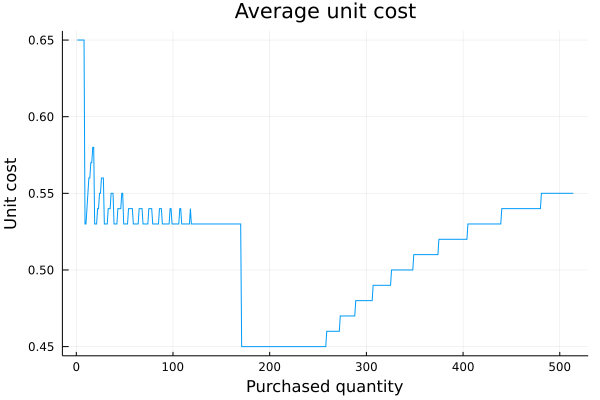

In [25]:
plot(
    quantities, pack_results.unit_cost;
    label=:none, 
    title="Average unit cost",
    xlabel="Purchased quantity",
    ylabel="Unit cost"
    )

### Observations

We show rows 165 through 175 of the DataFrame, as they show the selection of the bulk-pricing option $x_3$. Observe that $x_3$'s value jumps from 0 to 20 and that $x_2$'s value jumps from 17 to 0, due to constraints 3 and 4.

In [26]:
pack_results[165:175,:]

,quantity,x₁,x₂,x₃,total_cost,waste,unit_cost
,Int64,Int64,Int64,Int64,Any,Int64,Float64
1,165,5,16,0,87.57,0,0.53
2,166,6,16,0,88.22,0,0.53
3,167,7,16,0,88.87,0,0.53
4,168,8,16,0,89.52,0,0.53
5,169,0,17,0,89.59,1,0.53
6,170,0,17,0,89.59,0,0.53
7,171,0,0,20,89.6,29,0.45
8,172,0,0,20,89.6,28,0.45
9,173,0,0,20,89.6,27,0.45


Of interest is the fact that if the electrician needed 170 plates, they could in fact get 29 extra plates for only 0.01 extra in total cost. The average unit cost drops from 0.53 to 0.45. While this wouldn't be mathematically optimal for the electrician's required quantity, it might still be useful for the electrician to see when making a purchase decision.

This illustrates the fact that linear programs are useful for decision *support*, and their results should be considered alongside other information. They operate on models, which are lossy abstractions of real-world problems. For this reason, it is useful to run the solver for multiple values, since this can help reveal information that may not have been considered when creating the model.

## Fertilizer bag selection

A landscaper needs to buy bags of fertilizer. The garden store has the following in stock:

- 83 bags of 25 lb each, costing 8.50
- 65 bags of 50 lb each, costing 15.00 for quantities less than 25, and costing 12.00 for quantities of 25 or more

The garden store is running the following promotions:

1. 5.00 off of any purchase of 20.00 or more
2. 10.00 off of any purchase of 50.00 or more

Only one offer can be selected for a given purchase.

Given a quantity of fertilizer needed, how does the landscaper choose how many of each bag to purchase in order to minimize total cost?

We can represent this problem as an integer linear program. In this approach, our program will minimize the objective function $\mathbf{bag\_cost}\cdot\mathbf{x} + \mathbf{coupon}\cdot\mathbf{y}$, where $\mathbf{bag\_cost}$ is a vector of costs for each fertilizer bag, $\mathbf{x}$ is a vector of decision variables where each $x_i \in \mathbf{x}$ represents the number of bags to be purchased for $i$ size, $\mathbf{coupon}$ is a vector of available discounts, and $\mathbf{y}$ is a vector of decision variables where each $y_i \in \mathbf{y}$ represents whether that discount is applied or not.

Our program is subject to the following constraints:

1. $\mathbf{x} \in \mathbb{Z}$, since the landscaper can't purchase part of a pack.
2. $0 \preceq \mathbf{x} \preceq \mathbf{bag\_count}$, where $\mathbf{bag\_count}$ is a vector of how many bags are in stock for each size.
3. $x_3 \in \{0\}\cup \left[25,\mathit{bag\_count_3}\right]$, where $\mathit{bag\_count_3}$ is the number of bags in stock for the 50-lb size.
4. $x_2 + x_3 \leq \mathit{bag\_count_3}$, since $x_2$ and $x_3$ both represent quantities of the same 50-lb bags.
5. $\mathbf{bag\_capacity} \cdot \mathbf{x} \geq \mathit{quantity}$, where $\mathbf{bag\_capacity}$ is a vector of the size of each bag, and $\mathit{quantity}$ is the amount of fertilizer the lanscaper needs.
6. $y_i \in \{0,1\} \forall y_i \in \mathbf{y}$, since an offer can be selected or not.
7. $\sum_i y_i \leq 1 \forall y_i \in \mathbf{y}$, since only one offer can be selected at max.
8. $y_1 \implies \mathbf{bag\_cost}\cdot\mathbf{x} \geq 20.00$, where $\mathit{coupon_1} = -5.00$, since offer 1 requires the total purchase to be 20.00 or more.
9. $y_2 \implies \mathbf{bag\_cost}\cdot\mathbf{x} \geq 50.00$, where $\mathit{coupon_2} = -10.00$, since offer 2 requires the total purchase to be 50.00 or more.

We define $\mathbf{bag\_cost}$, $\mathbf{bag\_capacity}$, and $\mathbf{bag\_count}$. 

In [27]:
bag_cost = [8.50, 15.00, 12.00];
bag_capacity = [25, 50, 50];
bag_count = [83, 65, 65];

We initialize the solver.

In [28]:
using Cbc;

In [29]:
bag_model = Model(Cbc.Optimizer);

We define $\mathbf{x}$, as well as constraints 1 and 2.

In [30]:
@variable(bag_model, x[1:size(bag_count,1)], Int)

@constraint(bag_model, 0 .<= x[1:size(bag_count,1)] .<= bag_count)

3-element Vector{ConstraintRef{Model, MathOptInterface.ConstraintIndex{MathOptInterface.ScalarAffineFunction{Float64}, MathOptInterface.Interval{Float64}}, ScalarShape}}:
 x[1] ∈ [0.0, 83.0]
 x[2] ∈ [0.0, 65.0]
 x[3] ∈ [0.0, 65.0]

We define constraints 3 and 4.

In [31]:
@constraint(bag_model, x[3] in MOI.Semiinteger(25.0, Float64(bag_count[3])))
@constraint(bag_model, sum(x[2:3]) <= bag_count[3])

x[2] + x[3] ≤ 65.0

We define $\mathbf{coupon}$ and $\mathbf{y}$, as well as constraints 6 through 9.

In [32]:
coupon = [-5.00, -10.00];

@variable(bag_model, y[1:size(coupon, 1)], Bin)

@constraint(bag_model, sum(y) <= 1)
@constraint(bag_model, y[1] => {dot(bag_cost, x) >= 20.00})
@constraint(bag_model, y[2] => {dot(bag_cost, x) >= 50.00})

y[2] => {8.5 x[1] + 15 x[2] + 12 x[3] ≥ 50.0}

We define our objective function.

In [33]:
@objective(bag_model, Min, dot(bag_cost, x) + dot(coupon, y))

8.5 x[1] + 15 x[2] + 12 x[3] - 5 y[1] - 10 y[2]

We implement constraint 5, and run our solver for every value $\{ \mathit{quantity} | \mathit{quantity}\in\mathbb{Z}\wedge\mathit{quantity}\mod 25 = 0 \wedge 0 \leq \mathit{quantity} \leq \sum_{i=1}^2 c_i n_i \forall c_i,n_i \in \mathbf{bag\_capacity},\mathbf{bag\_count} \}$.

In [34]:
@constraint(bag_model, total_capacity, dot(bag_capacity, x) >= 0)
bag_counts = []
discounts = []
bag_prices = []

quantities = 0:25:dot(bag_capacity[1:2], bag_count[1:2])

set_silent(bag_model);
for quantity in quantities
    set_normalized_rhs(total_capacity, quantity)
    optimize!(bag_model);
    push!(bag_counts, transpose(value.(x)))
    push!(discounts, transpose(value.(y)))
    push!(bag_prices, objective_value(bag_model))
end

We print our model after the run.

In [35]:
print(bag_model)

Min 8.5 x[1] + 15 x[2] + 12 x[3] - 5 y[1] - 10 y[2]
Subject to
 total_capacity : 25 x[1] + 50 x[2] + 50 x[3] ≥ 5325.0
 x[2] + x[3] ≤ 65.0
 y[1] + y[2] ≤ 1.0
 x[1] ∈ [0.0, 83.0]
 x[2] ∈ [0.0, 65.0]
 x[3] ∈ [0.0, 65.0]
 x[3] ∈ MathOptInterface.Semiinteger{Float64}(25.0, 65.0)
 x[1] integer
 x[2] integer
 x[3] integer
 y[1] binary
 y[2] binary
 y[1] => {8.5 x[1] + 15 x[2] + 12 x[3] ≥ 20.0}
 y[2] => {8.5 x[1] + 15 x[2] + 12 x[3] ≥ 50.0}


We show the results of the solver as a DataFrame (truncated to 30 rows). The first column is the required quantity. The second through fourth columns are the values for each $x_i \in \mathbf{x}$. The fifth and sixth columns are the values for each $y_i \in \mathbf{y}$. The seventh column is the total cost. The eighth column is the difference between the purchased quantity and required quantity for each solution, which represents the waste/excess. The ninth column is the average unit cost of a pound of fertilizer for the purchased quantity.

In [36]:
bag_results = DataFrame(
    quantity = quantities,
    x₁ = (Int64∘round).(vcat(bag_counts...)[:,1]),
    x₂ = (Int64∘round).(vcat(bag_counts...)[:,2]),
    x₃ = (Int64∘round).(vcat(bag_counts...)[:,3]),
    y₁ = Bool.(vcat(discounts...)[:,1]),
    y₂ = Bool.(vcat(discounts...)[:,2]),
    total_cost = bag_prices,
    waste = (Int64∘round).((vcat(bag_counts...) * bag_capacity)-quantities),
    unit_cost = round.(bag_prices ./ (vcat(bag_counts...) * bag_capacity); digits=2)
)

,quantity,x₁,x₂,x₃,y₁,y₂,total_cost,waste,unit_cost
,Int64,Int64,Int64,Int64,Bool,Bool,Any,Int64,Float64
1,0,0,0,0,0,0,0.0,0,NaN
2,25,1,0,0,0,0,8.5,0,0.34
3,50,0,1,0,0,0,15.0,0,0.3
4,75,1,1,0,1,0,18.5,0,0.25
5,100,0,2,0,1,0,25.0,0,0.25
6,125,1,2,0,1,0,33.5,0,0.27
7,150,0,3,0,1,0,40.0,0,0.27
8,175,1,3,0,0,1,43.5,0,0.25
9,200,0,4,0,0,1,50.0,0,0.25


We plot the results of the total cost as dependent on the quantity.

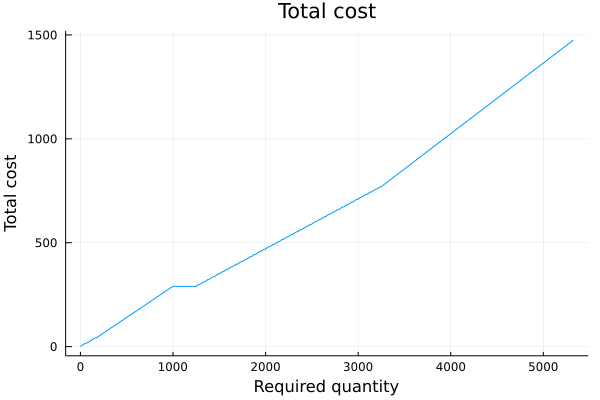

In [37]:
bag_total_cost = plot(
    quantities, bag_prices;
    label="Unlimited waste/excess allowed",
    title="Total cost",
    legend=:none,
    xlabel="Required quantity",
    ylabel="Total cost"
)

We plot the waste/excess as dependent on the required quantity.

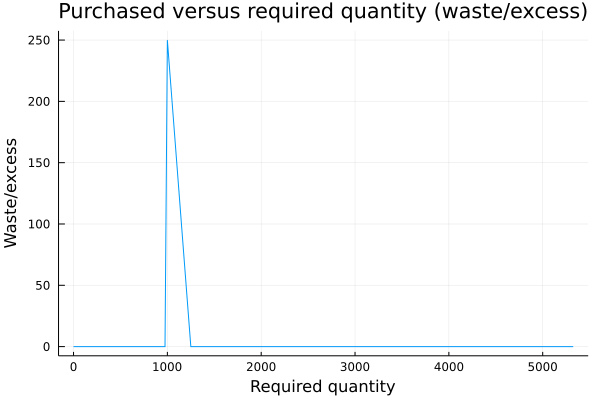

In [38]:
bag_waste = plot(
    quantities, bag_results.waste;
    label="Unlimited waste/excess allowed",
    legend=:none,
    title="Purchased versus required quantity (waste/excess)",
    xlabel="Required quantity",
    ylabel="Waste/excess"
    )

We calculate the maximum possible waste/excess.

In [39]:
maximum(bag_results.waste)

250

We plot the average unit cost as dependent on purchased quantity.

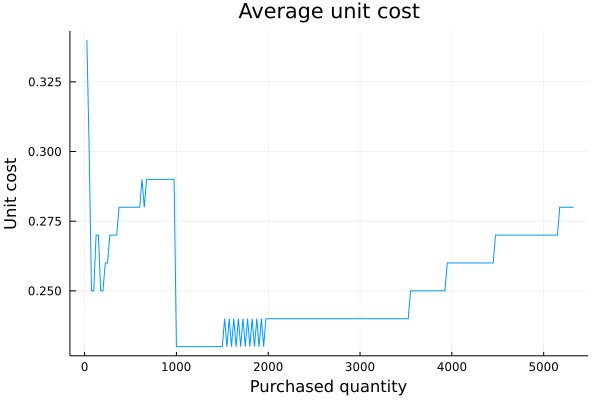

In [40]:
bag_unit_cost = plot(
    quantities, bag_results.unit_cost;
    label="Unlimited waste/excess allowed",
    legend=:none,
    title="Average unit cost",
    xlabel="Purchased quantity",
    ylabel="Unit cost"
    )

### Observations

We see that there is the possibility for considerable waste/excess. This is caused by constraint 5, since it allows for purchased quantities greater than the required quantity. We can disallow this inequality in order to eliminate waste/excess.

We revise constraint 5 to enforce equality, and rerun our solver.

In [41]:
delete(bag_model, total_capacity)
@constraint(bag_model, total_capacity_exact, dot(bag_capacity, x) == 0)
bag_counts_exact = []
discounts_exact = []
bag_prices_exact = []

quantities = 0:25:dot(bag_capacity[1:2], bag_count[1:2])

set_silent(bag_model);
for quantity in quantities
    set_normalized_rhs(total_capacity_exact, quantity)
    optimize!(bag_model);
    push!(bag_counts_exact, transpose(value.(x)))
    push!(discounts_exact, transpose(value.(y)))
    push!(bag_prices_exact, objective_value(bag_model))
end

We print our modified model after the run.

In [42]:
print(bag_model)

Min 8.5 x[1] + 15 x[2] + 12 x[3] - 5 y[1] - 10 y[2]
Subject to
 total_capacity_exact : 25 x[1] + 50 x[2] + 50 x[3] = 5325.0
 x[2] + x[3] ≤ 65.0
 y[1] + y[2] ≤ 1.0
 x[1] ∈ [0.0, 83.0]
 x[2] ∈ [0.0, 65.0]
 x[3] ∈ [0.0, 65.0]
 x[3] ∈ MathOptInterface.Semiinteger{Float64}(25.0, 65.0)
 x[1] integer
 x[2] integer
 x[3] integer
 y[1] binary
 y[2] binary
 y[1] => {8.5 x[1] + 15 x[2] + 12 x[3] ≥ 20.0}
 y[2] => {8.5 x[1] + 15 x[2] + 12 x[3] ≥ 50.0}


We display the new results in a new DataFrame.

In [43]:
bag_results_exact = DataFrame(
    quantity = quantities,
    x₁ = (Int64∘round).(vcat(bag_counts_exact...)[:,1]),
    x₂ = (Int64∘round).(vcat(bag_counts_exact...)[:,2]),
    x₃ = (Int64∘round).(vcat(bag_counts_exact...)[:,3]),
    y₁ = Bool.(vcat(discounts_exact...)[:,1]),
    y₂ = Bool.(vcat(discounts_exact...)[:,2]),
    total_cost = bag_prices_exact,
    waste = (Int64∘round).((vcat(bag_counts_exact...) * bag_capacity)-quantities),
    unit_cost = round.(bag_prices_exact ./ (vcat(bag_counts_exact...) * bag_capacity); digits=2)
)

,quantity,x₁,x₂,x₃,y₁,y₂,total_cost,waste,unit_cost
,Int64,Int64,Int64,Int64,Bool,Bool,Any,Int64,Float64
1,0,0,0,0,0,0,0.0,0,NaN
2,25,1,0,0,0,0,8.5,0,0.34
3,50,0,1,0,0,0,15.0,0,0.3
4,75,1,1,0,1,0,18.5,0,0.25
5,100,0,2,0,1,0,25.0,0,0.25
6,125,1,2,0,1,0,33.5,0,0.27
7,150,0,3,0,1,0,40.0,0,0.27
8,175,1,3,0,0,1,43.5,0,0.25
9,200,0,4,0,0,1,50.0,0,0.25


We plot the new results of the total cost as dependent on the required quantity. We show a detail section of the plot to highlight the difference between the old and new results.

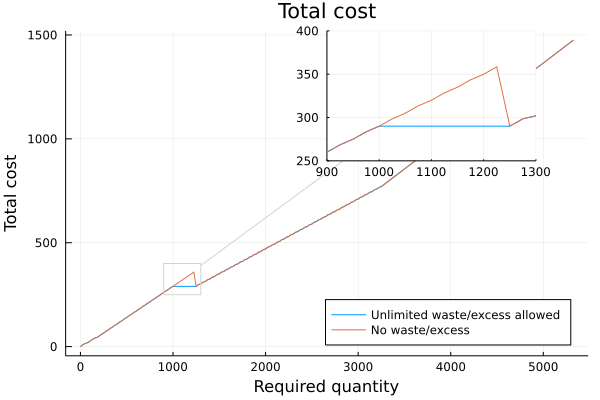

In [44]:
plot!(bag_total_cost,
    quantities, bag_prices_exact;
    label="No waste/excess",
    legend=:bottomright,
)
t = lens!([900, 1300], [250, 400]; inset = (1, bbox(0.5, 0.0, 0.4, 0.4)), subplot=2)

We plot the new waste/excess as dependent on the required quantity.

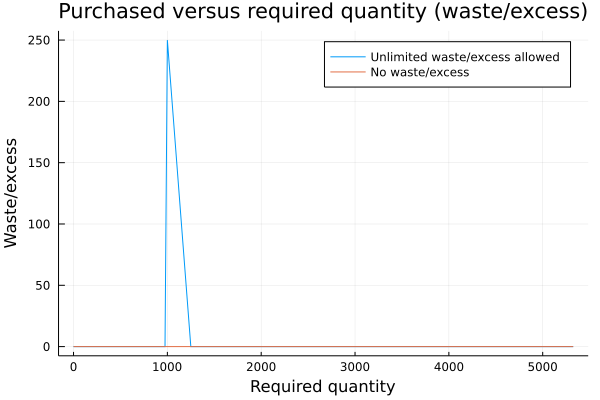

In [45]:
plot!(bag_waste,
    quantities, bag_results_exact.waste;
    label="No waste/excess",
    legend=:best,
    )

We calculate the new maximum possible waste/excess.

In [46]:
maximum(bag_results_exact.waste)

0

We plot the new average unit cost as dependent on purchased quantity.

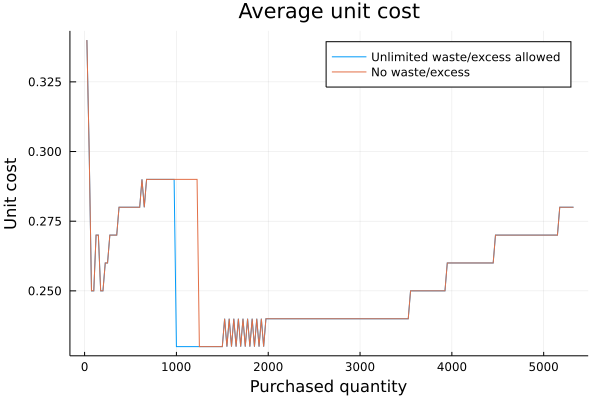

In [47]:
plot!(bag_unit_cost,
    quantities, bag_results_exact.unit_cost;
    label="No waste/excess",
    legend=:best,
    )

We can see that minimizing *waste/excess* is not the same as minimizing *cost*. In fact, a zero-waste constraint will never result in an objective value better than that of a waste-allowed constraint, since a waste-allowed constraint is less strict and allows the solver more leeway in finding an optimal value.

Instead of choosing between zero waste/excess and potentially-unlimited waste/excess, we can place a finite nonzero upper bound on the allowed waste/excess. For example, the landscaper might be okay with purchasing up to 100 excess pounds of fertilizer.

We revise constraint 5 to enforce this finite nonzero upper bound, and rerun our solver.

In [48]:
delete(bag_model, total_capacity_exact)

bag_counts_ub = []
discounts_ub = []
bag_prices_ub = []
bag_wastes_ub = []

quantities = 0:25:dot(bag_capacity[1:2], bag_count[1:2])

set_silent(bag_model);
for (index, quantity) in enumerate(quantities)
    total_capacity_ub = @constraint(bag_model, (100 + quantity) >= dot(bag_capacity, x) >= (0 + quantity))
    set_name(total_capacity_ub, "total_capacity_ub")
    optimize!(bag_model);
    push!(bag_counts_ub, transpose(value.(x)))
    push!(discounts_ub, transpose(value.(y)))
    push!(bag_prices_ub, objective_value(bag_model))
    push!(bag_wastes_ub, (Int64∘round).(dot(value.(x), bag_capacity)-quantity))
    if index != length(quantities) 
        delete(bag_model, total_capacity_ub)
    end
end

We print our model after the run.

In [49]:
print(bag_model)

Min 8.5 x[1] + 15 x[2] + 12 x[3] - 5 y[1] - 10 y[2]
Subject to
 x[2] + x[3] ≤ 65.0
 y[1] + y[2] ≤ 1.0
 x[1] ∈ [0.0, 83.0]
 x[2] ∈ [0.0, 65.0]
 x[3] ∈ [0.0, 65.0]
 total_capacity_ub : 25 x[1] + 50 x[2] + 50 x[3] ∈ [5325.0, 5425.0]
 x[3] ∈ MathOptInterface.Semiinteger{Float64}(25.0, 65.0)
 x[1] integer
 x[2] integer
 x[3] integer
 y[1] binary
 y[2] binary
 y[1] => {8.5 x[1] + 15 x[2] + 12 x[3] ≥ 20.0}
 y[2] => {8.5 x[1] + 15 x[2] + 12 x[3] ≥ 50.0}


We plot the new results of the total cost as dependent on the required quantity. We show a detail of the plot to highlight the difference between the old and new results.

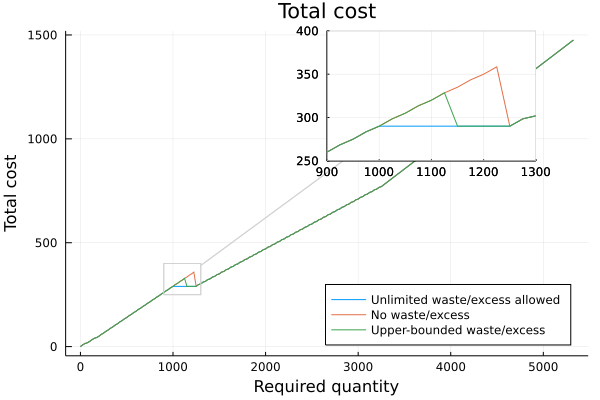

In [50]:
plot!(bag_total_cost,
    quantities, bag_prices_ub;
    label="Upper-bounded waste/excess",
    legend=:bottomright,
)
lens!(t, [900, 1300], [250, 400]; inset = (1, bbox(0.5, 0.0, 0.4, 0.4)))

We plot the new waste/excess as dependent on the required quantity.

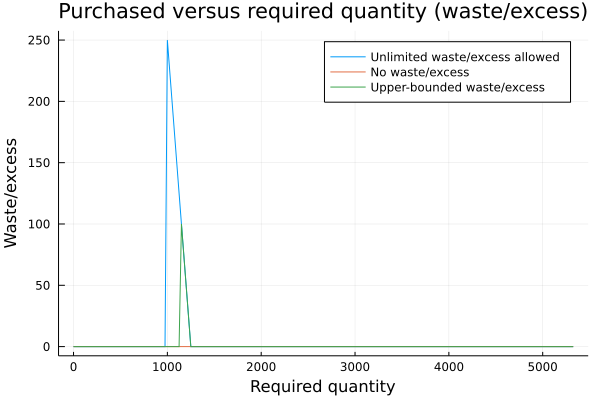

In [51]:
plot!(bag_waste,
    quantities, bag_wastes_ub;
    label="Upper-bounded waste/excess",
    legend=:best,
    )

We calculate the new maximum possible waste/excess.

In [52]:
maximum(bag_wastes_ub)

100

## Assembly line worker selection

A supervisor needs to arrange workers on an assembly line. Each worker can only perform one task at a time. A time study was performed earlier, and the results were tabulated:

| Task | Worker 1 | Worker 2 | Worker 3 | Worker 4 | Worker 5 | Worker 6 | Worker 7 | Worker 8 |
| --- | --- | --- | --- | --- | --- | --- | --- | --- |
| Task 1 | 50 | 58 | 62 | 66 | 72 | 67 | 63 | 61 |
| Task 2 | 42 | 30 | 35 | 40 | 50 | 47 | 36 | 43 |
| Task 3 | 30 | 26 | 31 | 34 | 16 | 27 | 38 | 45 |
| Task 4 | 22 | 32 | 26 | 36 | 26 | 30 | 38 | 35 |
| Task 5 | 37 | 34 | 50 | 47 | 46 | 38 | 59 | 45 |
| Task 6 | 42 | 40 | 55 | 34 | 13 | 24 | 25 | 30 |

How should the supervisor choose to assign a worker to each task in such a way that minimizes the total time?

We can represent this problem as an integer linear program. In this approach, our program will minimize the objective function $\sum_j\sum_i w_{i,j} \forall w_{i,j} \in \mathbf{task\_time}\odot\mathbf{x}$, where $\mathbf{task\_time}$ is a matrix of time measurements in which each $t_{i,j} \in \mathbf{task\_time}$ is worker $j$'s time for each task $i$, $\mathbf{x}$ is a matrix of decision variables in which $x_{i,j} \in \mathbf{x}$ represents whether worker $j$ will be assigned to task $i$ or not, and $\odot$ represents the [Hadamard product](https://en.wikipedia.org/wiki/Hadamard_product_%28matrices%29) ($t_{i,j}x_{i,j} \forall t_{i,j}, x_{i,j} \in \mathbf{task\_time}, \mathbf{x}$).

Our program is subject to the following constraints:

1. $x_{i,j} \in \{0,1\} \forall x_{i,j} \in \mathbf{x}$, since a worker can either be assigned to a task or not.
2. $\sum_i x_{i,j} = 1\forall x_{i,j} \in \mathbf{x}$, since each task needs exactly one worker assigned to it.
3. $\sum_j x_{i,j} \leq 1\forall x_{i,j} \in \mathbf{x}$, since each worker can be assigned to only one task at maximum.

We define $\mathbf{task\_time}$.

In [82]:
task_time = [
    50 58 62 66 72 67 63 61;
    42 30 35 40 50 47 36 43;
    30 26 31 34 16 27 38 45;
    22 32 26 36 26 30 38 35;
    37 34 50 47 46 38 59 45;
    42 40 55 34 13 24 25 30;
];

We initialize the solver.

In [83]:
task_model = Model(GLPK.Optimizer);

We define $\mathbf{x}$, as well as constraints 1, 2, and 3.

In [84]:
@variable(task_model, x[1:size(task_time,1), 1:size(task_time,2)], Bin)

for i in 1:size(x,1)
    @constraint(task_model, sum(x[i,:]) == 1)
end

for j in 1:size(x,2)
    @constraint(task_model, sum(x[:,j]) <= 1)
end

We define our objective function.

In [85]:
@objective(task_model, Min, sum(task_time .* x))

50 x[1,1] + 42 x[2,1] + 30 x[3,1] + 22 x[4,1] + 37 x[5,1] + 42 x[6,1] + 58 x[1,2] + 30 x[2,2] + 26 x[3,2] + 32 x[4,2] + 34 x[5,2] + 40 x[6,2] + 62 x[1,3] + 35 x[2,3] + 31 x[3,3] + 26 x[4,3] + 50 x[5,3] + 55 x[6,3] + 66 x[1,4] + 40 x[2,4] + 34 x[3,4] + 36 x[4,4] + 47 x[5,4] + 34 x[6,4] + 72 x[1,5] + 50 x[2,5] + 16 x[3,5] + 26 x[4,5] + 46 x[5,5] + 13 x[6,5] + 67 x[1,6] + 47 x[2,6] + 27 x[3,6] + 30 x[4,6] + 38 x[5,6] + 24 x[6,6] + 63 x[1,7] + 36 x[2,7] + 38 x[3,7] + 38 x[4,7] + 59 x[5,7] + 25 x[6,7] + 61 x[1,8] + 43 x[2,8] + 45 x[3,8] + 35 x[4,8] + 45 x[5,8] + 30 x[6,8]

We print our model.

In [86]:
print(task_model)

Min 50 x[1,1] + 42 x[2,1] + 30 x[3,1] + 22 x[4,1] + 37 x[5,1] + 42 x[6,1] + 58 x[1,2] + 30 x[2,2] + 26 x[3,2] + 32 x[4,2] + 34 x[5,2] + 40 x[6,2] + 62 x[1,3] + 35 x[2,3] + 31 x[3,3] + 26 x[4,3] + 50 x[5,3] + 55 x[6,3] + 66 x[1,4] + 40 x[2,4] + 34 x[3,4] + 36 x[4,4] + 47 x[5,4] + 34 x[6,4] + 72 x[1,5] + 50 x[2,5] + 16 x[3,5] + 26 x[4,5] + 46 x[5,5] + 13 x[6,5] + 67 x[1,6] + 47 x[2,6] + 27 x[3,6] + 30 x[4,6] + 38 x[5,6] + 24 x[6,6] + 63 x[1,7] + 36 x[2,7] + 38 x[3,7] + 38 x[4,7] + 59 x[5,7] + 25 x[6,7] + 61 x[1,8] + 43 x[2,8] + 45 x[3,8] + 35 x[4,8] + 45 x[5,8] + 30 x[6,8]
Subject to
 x[1,1] + x[1,2] + x[1,3] + x[1,4] + x[1,5] + x[1,6] + x[1,7] + x[1,8] = 1.0
 x[2,1] + x[2,2] + x[2,3] + x[2,4] + x[2,5] + x[2,6] + x[2,7] + x[2,8] = 1.0
 x[3,1] + x[3,2] + x[3,3] + x[3,4] + x[3,5] + x[3,6] + x[3,7] + x[3,8] = 1.0
 x[4,1] + x[4,2] + x[4,3] + x[4,4] + x[4,5] + x[4,6] + x[4,7] + x[4,8] = 1.0
 x[5,1] + x[5,2] + x[5,3] + x[5,4] + x[5,5] + x[5,6] + x[5,7] + x[5,8] = 1.0
 x[6,1] + x[6,2] + x[6,3] 

We run our solver.

In [87]:
optimize!(task_model);

We show the selected assignments as a DataFrame. Each column represents a worker, and each row represents a task. Non-assignment is represented by blank cells, while assignment is represented by populated cells, with the cell value representing that worker's time for that task.

In [88]:
task_result = DataFrame(
    map(enumerate((Bool∘value).(x))) do (index, value)
        value ? task_time[index] : ""
    end,
    :auto
)

,x1,x2,x3,x4,x5,x6,x7,x8
,Any,Any,Any,Any,Any,Any,Any,Any
1,50,,,,,,,
2,,30,,,,,,
3,,,,,16,,,
4,,,26,,,,,
5,,,,,,38,,
6,,,,,,,25,


We print the value for our objective function.

In [89]:
objective_value(task_model)

185.0

### Observations

We could have solved this problem with a simpler approach: for each task $i$, find the minimum time $t_{i,j}$, record its value and indices, then remove that $i$th, $j$th row and column from the matrix and repeat. 

The advantage of using a linear programming approach is that it saves us the effort of having to implement that simpler approach. In fact, this is one of the biggest advantages of linear programming: it can apply a relatively small number of well-understood reasonably-performant algorithms to solve a wide variety of problems of varying dimensionality.